# Intel® Extension for PyTorch (IPEX)

Intel® Extension for PyTorch is a Python package to extend official PyTorch. It is designed to make the Out-of-Box user experience of PyTorch CPU better while achieving good performance. The extension brings new functions, but also ofurther ptimizations (for example, take advantage of Intel's new hardware features).

In [1]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image

In [2]:
net = torchvision.models.resnet50(pretrained=False)
net.eval()

/opt/intel/inteloneapi/pytorch/latest/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/intel/inteloneapi/pytorch/latest/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
img = Image.open('content/flower.jpg').convert('RGB')
resize = transforms.Resize([1280, 1920])
img = resize(img)
to_tensor = transforms.ToTensor()
tensor = to_tensor(img)
data = tensor.unsqueeze(0) # torch.Size([1, 3, 224, 224])

## Performance evaluations

We conduct several tests with and without IPEX and for each test, we further evaluate running in Python as as well in JIT mode, that is, natively (outside Python).

The following tests will be conducted:

*With IPEX disabled:*

1. Within PyTorch
2. Natively

*With IPEX enabled:*

3. Within PyTorch
4. Natively



#### Without IPEX, in PyTorch

In [4]:
import time
time_no_ipex_obj = %timeit -r10 -o net(data)
print('Runtime: {} s'.format(time_no_ipex_obj))

1.42 s ± 78.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Runtime: 1.42 s ± 78.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each) s


In [5]:
time_no_ipex = time_no_ipex_obj.best

#### Without IPEX, with TorchScript

TorchScript is a way to create serializable and optimizable models from PyTorch code. Any TorchScript program can be saved from a Python process and loaded in a process where there is no Python dependency.

With Torchscript, a pure Python programcan be run independently from Python, such as in a standalone C++ program. This makes it possible to train models in PyTorch using familiar tools in Python and then export the model via TorchScript to a production environment where Python programs may be disadvantageous for performance and multi-threading reasons.

In [6]:
net = torch.jit.trace(net, data)
time_no_ipex_native_obj = %timeit -r10 -o net(data)
print('Runtime: {} s'.format(time_no_ipex_native_obj))

1.48 s ± 39.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Runtime: 1.48 s ± 39.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each) s


In [7]:
time_no_ipex_native = time_no_ipex_native_obj.best

#### With IPEX, in PyTorch

To explore the Intel® Extension for PyTorch, you just need to convert the model and input tensors to the extension device, then the extension will be enabled automatically. 

Let's first reset the network from being jitted.

In [8]:
net = torchvision.models.resnet50(pretrained=False)
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
import intel_extension_for_pytorch as ipex
model = net.to(memory_format=torch.channels_last)
model = ipex.optimize(model)
data = data.to(memory_format=torch.channels_last)

In [10]:
time_with_ipex_obj = %timeit -r10 -o model(data)
print('Runtime: {} s'.format(time_with_ipex_obj))

788 ms ± 43.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Runtime: 788 ms ± 43.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each) s


In [11]:
time_with_ipex = time_with_ipex_obj.best

#### With IPEX, with TorchScript

In [13]:
model = torch.jit.trace(model, data)
time_with_ipex_native_obj = %timeit -r10 -o model(data)
print('Runtime: {} s'.format(time_with_ipex_native_obj))

830 ms ± 2.71 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Runtime: 830 ms ± 2.71 ms per loop (mean ± std. dev. of 10 runs, 1 loop each) s


In [14]:
time_with_ipex_native = time_with_ipex_native_obj.best

Let's now visualize the results. 

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

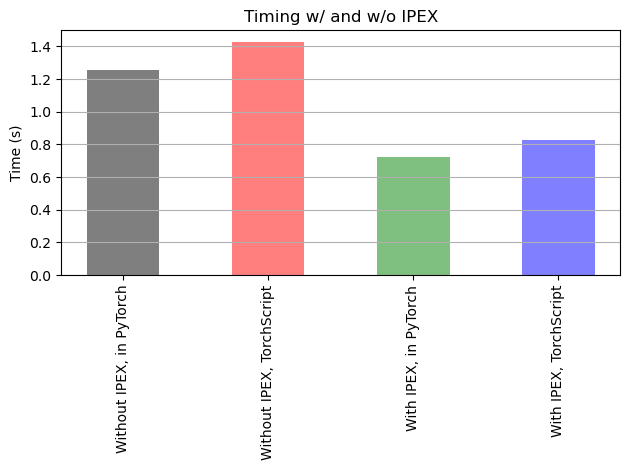

In [16]:
## Import data visualization packages

# Create arrays for the plot
x_axis = ['Without IPEX, in PyTorch', 'Without IPEX, TorchScript', 'With IPEX, in PyTorch', 'With IPEX, TorchScript']
x_pos = np.arange(len(x_axis))
y_axis = [time_no_ipex, time_no_ipex_native, time_with_ipex, time_with_ipex_native]


# Build the plot
fig, ax = plt.subplots()

ax.bar(x_pos, y_axis, align='center', width=0.5, alpha=0.5, color=['black', 'red', 'green', 'blue'])
ax.set_ylabel('Time (s)')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_axis)
plt.xticks(rotation = 90)
ax.set_title('Timing w/ and w/o IPEX')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot.png')
plt.show()

